In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## util

In [231]:
def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

In [232]:
def zscore(x):
    return (x - x.mean()) / x.std()

In [233]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [234]:
def calculateMetrics(y_test, y_pred):
    rmse = np.sqrt(np.mean((y_pred - y_test)*(y_pred - y_test)))
    mae = np.mean(np.abs(y_pred - y_test))
    mape = np.mean(np.abs(y_pred - y_test) / (y_test + 1e-0))
    r2 = (np.corrcoef(y_pred, y_test)[0,1])**2
    # r2 = r2_score(y_test, y_pred)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    print(f'R2: {r2}')

    # Calculate Pearson correlation coefficient
    pearson_corr, _ = pearsonr(y_test.flatten(), y_pred.flatten())
    print(f"Pearson correlation coefficient: {pearson_corr}")

    # Calculate Spearman correlation coefficient
    spearman_corr, _ = spearmanr(y_test.flatten(), y_pred.flatten())
    print(f"Spearman correlation coefficient: {spearman_corr}")

    return rmse, mae, mape, r2, pearson_corr, spearman_corr

## pre

In [399]:
match_id = 28

In [400]:
df_original = pd.read_csv(f"../data/Wimbledon_featured_matches_modified_add_features_with_momentum_{match_id}.csv")

In [401]:
momentum = df_original['momentum_normalized_average']

In [402]:
swing = momentum.diff().to_numpy()
swing = swing[1:]

In [403]:
momentum.shape, swing.shape

((217,), (216,))

In [404]:
# critical_points = df_original['critical_points_p1'].to_numpy()
# faults = df_original['faults_p1'].to_numpy()
# fatigue = df_original['fatigue_p1'].to_numpy()
# server = df_original['server'].to_numpy()

In [405]:
# critical_points.shape, faults.shape, fatigue.shape, server.shape

## factors related with swings (task 3.1)

In [406]:
# calculateMetrics(critical_points, momentum.to_numpy())

In [407]:
# calculateMetrics(faults, momentum.to_numpy())

In [408]:
# calculateMetrics(fatigue, momentum.to_numpy())

In [409]:
# calculateMetrics(critical_points[1:], swing)

In [410]:
# calculateMetrics(faults[1:], swing)

In [411]:
# calculateMetrics(fatigue[1:], swing)

In [412]:
# calculateMetrics(server[1:], swing)

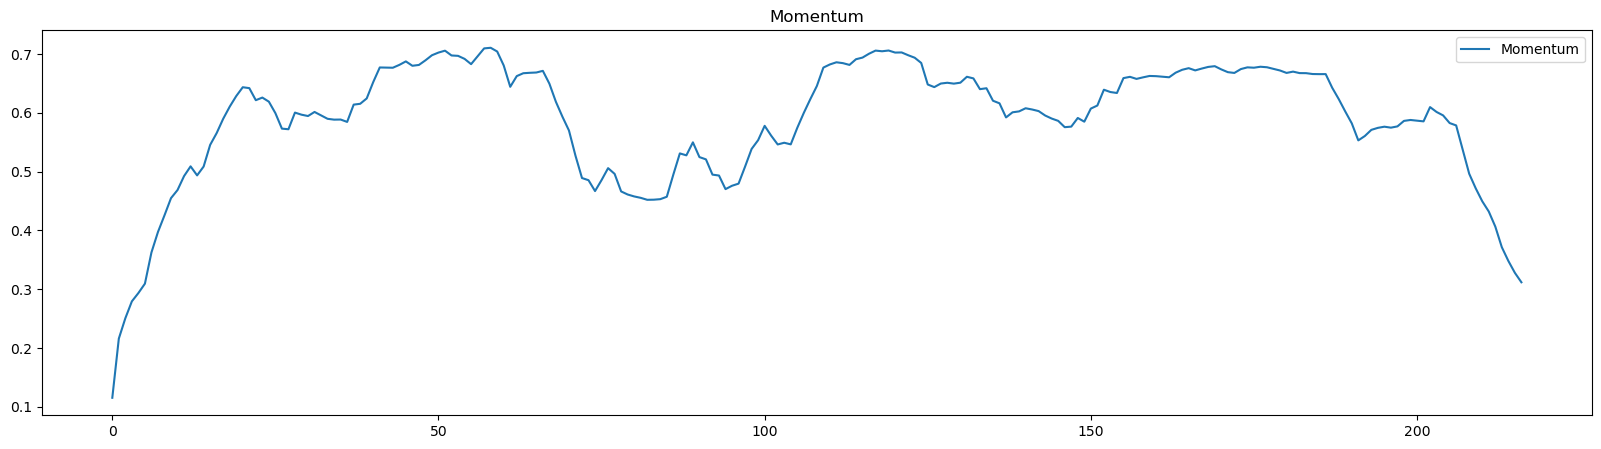

In [413]:
# plot momentum, swing
plt.figure(figsize=(20, 5))
plt.plot(momentum, label='Momentum')
# plt.plot(swing, label='Swing')
plt.title(f'Momentum')
# plt.title(f'Momentum_Match_{match_id}')
plt.legend()
plt.show()

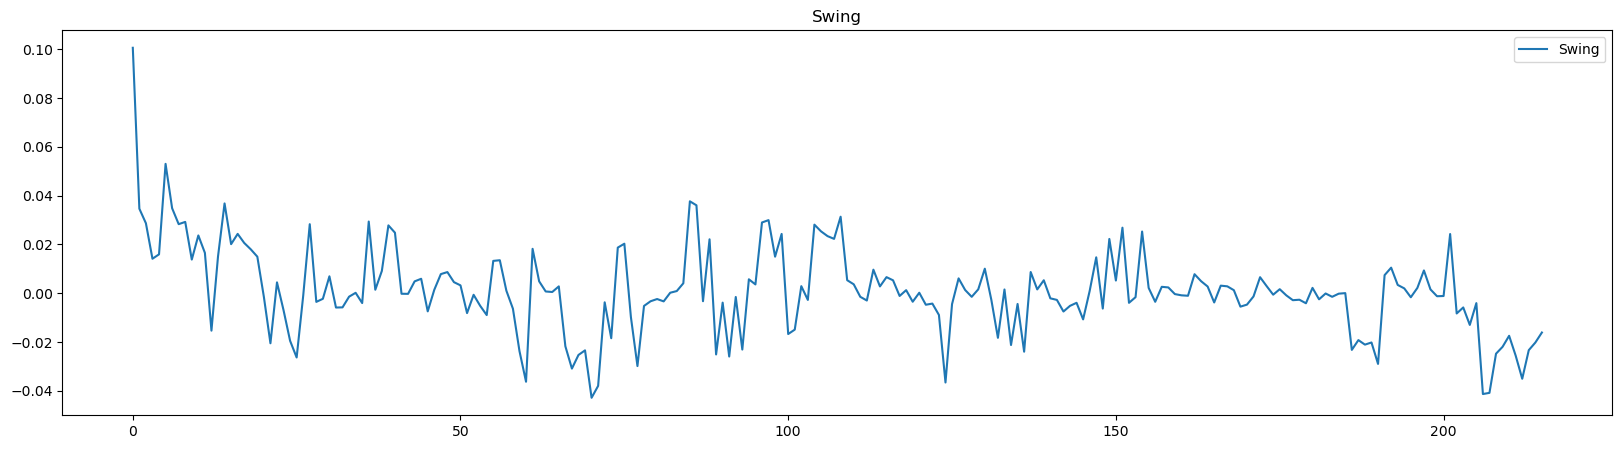

In [414]:
# plot momentum, swing
plt.figure(figsize=(20, 5))
# plt.plot(momentum, label='Momentum')
plt.plot(swing, label='Swing')
# plt.title(f'Swing_Match_{match_id}')
plt.title('Swing')
plt.legend()
plt.show()


## Momentum <-> swings in the play(points diff) - task 2.1

In [415]:
df_original['points_diff'] = df_original['p1_points_won'] - df_original['p2_points_won']
df_original['points_diff_normalized'] = minmax(df_original['points_diff'])

In [416]:
df_original["points_diff_diff"] = df_original['points_diff'].diff()

In [417]:
df_original['points_diff_average'] = df_original['points_diff'].rolling(window=10, min_periods=1).mean()

In [418]:
df_original['points_diff_average_diff'] = df_original['points_diff_average'].diff()

In [419]:
calculateMetrics(momentum[1:].to_numpy(), df_original['points_diff_average_diff'][1:].to_numpy())

RMSE: 0.7350930607493831
MAE: 0.6924361878198046
MAPE: 0.4356179838351146
R2: 0.06606008585867137
Pearson correlation coefficient: 0.2570215669135013
Spearman correlation coefficient: 0.3727468159066164


(0.7350930607493831,
 0.6924361878198046,
 0.4356179838351146,
 0.06606008585867137,
 0.2570215669135013,
 0.3727468159066164)

In [420]:
calculateMetrics(df_original['points_diff'].to_numpy(), momentum.to_numpy())

RMSE: 13.161486295460687
MAE: 11.009133242278379
MAPE: inf
R2: 0.00197985804974308
Pearson correlation coefficient: -0.04449559584658999
Spearman correlation coefficient: 0.07383006028414159


/var/folders/m2/zcwxrgy51pn1nvmjxw69mj9h0000gn/T/ipykernel_28353/613863332.py:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(y_pred - y_test) / (y_test + 1e-0))


(13.161486295460687,
 11.009133242278379,
 inf,
 0.00197985804974308,
 -0.04449559584658999,
 0.07383006028414159)

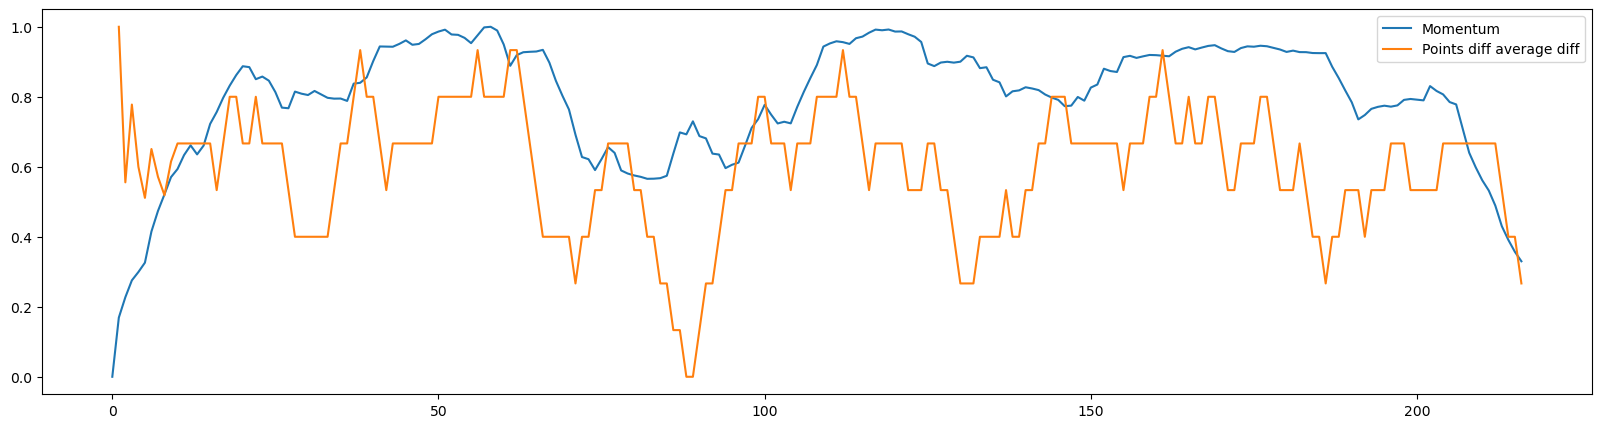

In [421]:
# plot momentum, points_diff
plt.figure(figsize=(20, 5))
plt.plot(minmax(momentum), label='Momentum')
# plt.plot(df_original['points_diff_normalized'], label='Points diff')
# plt.plot(minmax(df_original['points_diff_diff']), label='Points diff diff')
# plt.plot(minmax(df_original['points_diff_average']), label='Points diff average')
plt.plot(minmax(df_original['points_diff_average_diff']), label='Points diff average diff')
plt.legend()
plt.show()


## Momentum <-> runs of success Task(2.2) see [this](./assess_claim.ipynb)

## ARIMA for swing prediction

In [422]:
# swing = swing[1:]
swing.shape

(216,)

In [423]:
def ADF_test(df):
    result = ADF(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))

The Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. The importance of performing this test before applying time series models like ARIMA or LSTM is to check the stationarity of the series.

Stationarity is an important characteristic of time series data. A time series is said to be stationary if its statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most of the time series models work on the assumption that the time series is stationary.

ARIMA and LSTM models assume that the data is stationary. If the data is not stationary, the predictions made by these models will be unreliable.

The ADF test helps us to understand whether we need to make the series stationary (for example, by differencing the series) before we apply these models. If the ADF test fails to reject the null hypothesis, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

So, it's a good practice to perform ADF test before applying time series models.

In [424]:
ADF_test(swing)

ADF Statistic: -3.743548
p-value: 0.003541
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575


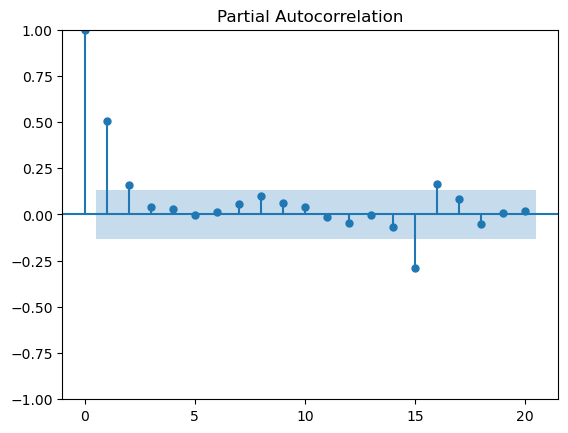

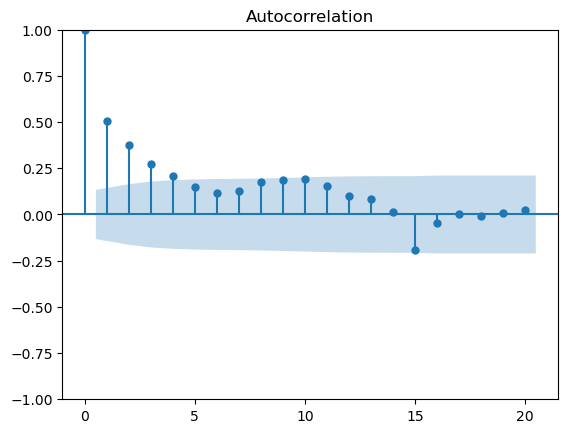

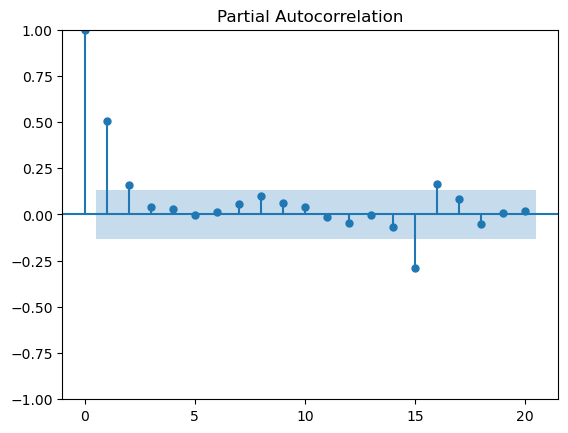

In [425]:
# plot acf plot pacf for swing
plot_acf(swing, lags=20)
plot_pacf(swing, lags=20)

https://blog.csdn.net/weixin_41013322/article/details/108801516

The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are useful tools to identify the order of the Autoregressive (AR) or Moving Average (MA) terms in an ARIMA model.

1. **Identifying the order of the AR term (p)**: The PACF plot is used to identify the order of the AR term. The PACF plot displays the correlation between a series and its lags. The point where the PACF cuts off (drops to 0) for the first time gives the order of the AR term. For example, if the PACF cuts off after 2 lags, then we can use an AR term of order 2 (AR(2)).

2. **Identifying the order of the MA term (q)**: The ACF plot is used to identify the order of the MA term. The ACF plot displays the autocorrelation between a series and its lags. The point where the ACF cuts off (drops to 0) for the first time gives the order of the MA term. For example, if the ACF cuts off after 1 lag, then we can use an MA term of order 1 (MA(1)).

Remember, these are just rules of thumb and the actual order of AR or MA terms can be higher than the point of cutoff. It's always a good idea to experiment with different orders and see which model gives the best fit.

Sure, here's a concise version:

1. **Train Model**: $\text{Model} = f(X_{1:n})$
2. **Predict**: $\hat{x}_{n+1} = \text{Model}(X_{1:n})$
3. **Update Model**: $\text{Model} = f(X_{1:n+1})$, then predict $\hat{x}_{n+2}$, and so on.

Here, $f$ is the model function, $X_{1:n}$ is the data up to time $n$, and $\hat{x}_{n+1}$ is the predicted value for time $n+1$.

In [426]:
def arima(series, p, d, q):

    model = ARIMA(series, order=(p, d, q)) 
    model_fit = model.fit()

    # # make prediction
    # yhat = model_fit.predict(len(series), len(series), typ='levels')
    # print(yhat)

    return model_fit

In [427]:
window_size = 10  # define the size of the sliding window
predictions = []  # store the predicted values

for i in range(len(swing) - window_size + 1):
    window = swing[i:i+window_size]  # get the current window
    model = arima(window, 4, 0, 2)  # fit the ARIMA model on the window
    pred = model.predict(start=window_size, end=window_size, typ='levels')  # make prediction for the next value
    predictions.append(pred[0])  # store the predicted value


/Users/yichao/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yichao/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/yichao/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yichao/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as s

In [428]:
calculateMetrics(swing[window_size - 1:], np.array(predictions))

RMSE: 0.015604118061538193
MAE: 0.012000437464282478
MAPE: 0.011986800033849046
R2: 0.2593747064846482
Pearson correlation coefficient: 0.5092884315244635
Spearman correlation coefficient: 0.42915300191577105


(0.015604118061538193,
 0.012000437464282478,
 0.011986800033849046,
 0.2593747064846482,
 0.5092884315244635,
 0.42915300191577105)

0      0.041208
1      0.041421
2      0.035820
3      0.028293
4      0.032473
         ...   
202   -0.018367
203   -0.017402
204   -0.022362
205   -0.025828
206   -0.026897
Length: 207, dtype: float64


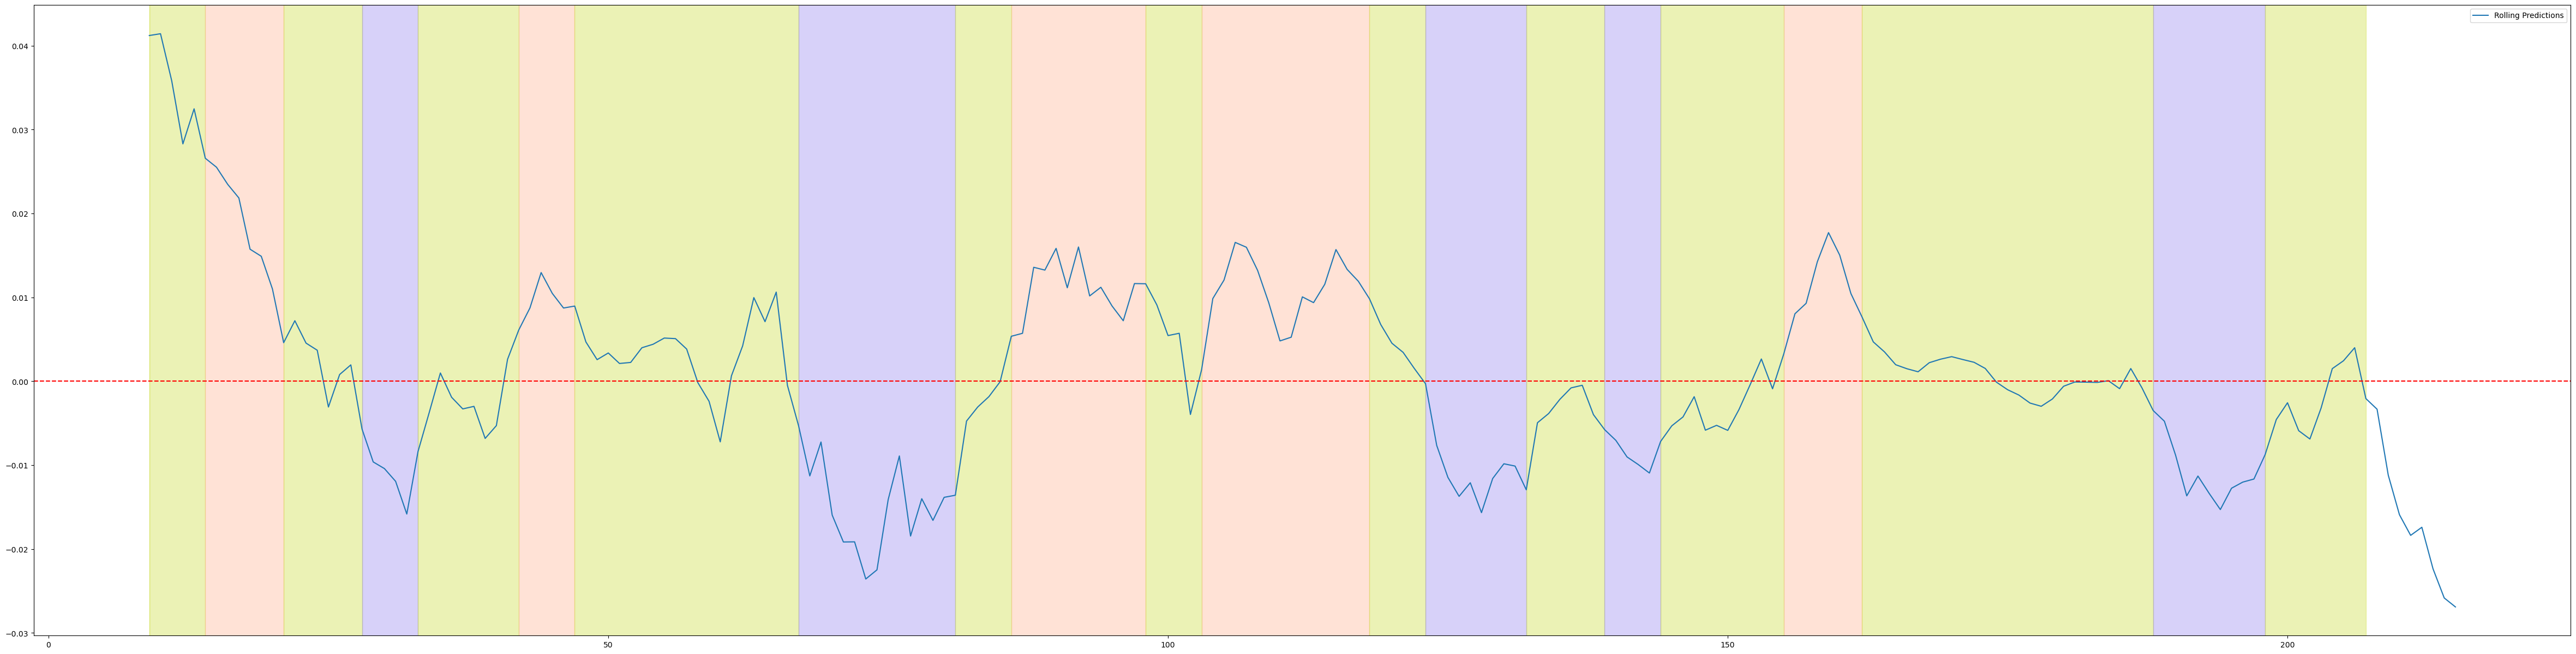

In [429]:
predictions_rolling = pd.Series(predictions).rolling(window=5, min_periods=1).mean()
import matplotlib.pyplot as plt

pos_index_list = []  
neg_index_list = []
zero_index_list=[0]

current_sum = 0
th = 0.007
current_state=0
sample_num=5
last_line=0
for i, value in enumerate(predictions_rolling):
    if(i<sample_num):
        continue
    j=0
    current_sum=predictions_rolling[i-1]
    while(j<sample_num):
        #current_sum=current_sum+predictions_rolling[i-j]
        current_sum=current_sum+predictions_rolling[min(i+j, len(predictions_rolling)-1)]
        j=j+1
    current_sum=current_sum/(sample_num+1)
    new_state=0
    if current_sum > th:
        new_state=1
    elif current_sum < -1*th:
        new_state =-1
    else:
        new_state =0
    if i-last_line < sample_num:
        continue
    if not new_state == current_state:
        if(new_state==1):
            pos_index_list.append(i)
        if(new_state==-1):
            neg_index_list.append(i)
        if(new_state==0):
            zero_index_list.append(i)
        current_state = new_state
        last_line=i
# plot the original swing data and the rolling predictions
plt.figure(figsize=(60, 15))
# plt.plot(swing, label='Original Swing')
plt.plot(range(window_size-1, len(swing)), predictions_rolling, label='Rolling Predictions')

last_color_edge=0
colorused = '#C0D70A'
pos_iter = neg_iter = zero_iter = 0
print(predictions_rolling)

for i in range(0, len(predictions_rolling)):
    if(i==pos_index_list[min(pos_iter, len(pos_index_list)-1)]):
        plt.axvspan(xmin=last_color_edge+window_size-1, xmax=i+window_size-1, color=colorused, alpha = 0.3)
        last_color_edge=i
        colorused='#FFA07A'
        pos_iter = pos_iter+1
    if(i==neg_index_list[min(neg_iter, len(neg_index_list)-1)]):
        plt.axvspan(xmin=last_color_edge+window_size-1, xmax=i+window_size-1, color=colorused, alpha = 0.3)
        last_color_edge=i
        colorused='#7B68EE'
        neg_iter = neg_iter+1
    if(i==zero_index_list[min(zero_iter, len(zero_index_list)-1)]):
        plt.axvspan(xmin=last_color_edge+window_size-1, xmax=i+window_size-1, color=colorused, alpha = 0.3)
        last_color_edge=i
        colorused='#C0D70A'
        zero_iter = zero_iter+1
        
#for index in pos_index_list:
#    plt.plot([index+window_size-1,index+window_size-1], [min(predictions_rolling), max(predictions_rolling)], 'r-') 
#for index in neg_index_list:
#    plt.plot([index+window_size-1,index+window_size-1], [min(predictions_rolling), max(predictions_rolling)], 'b-')  
#for index in zero_index_list:
#    plt.plot([index+window_size-1,index+window_size-1], [min(predictions_rolling), max(predictions_rolling)], 'g-')   
#add a line y = 0
plt.axhline(y=0, color='red', linestyle='--')
#plt.scatter(x=41, y=0,color='blue')
plt.legend()
plt.show()

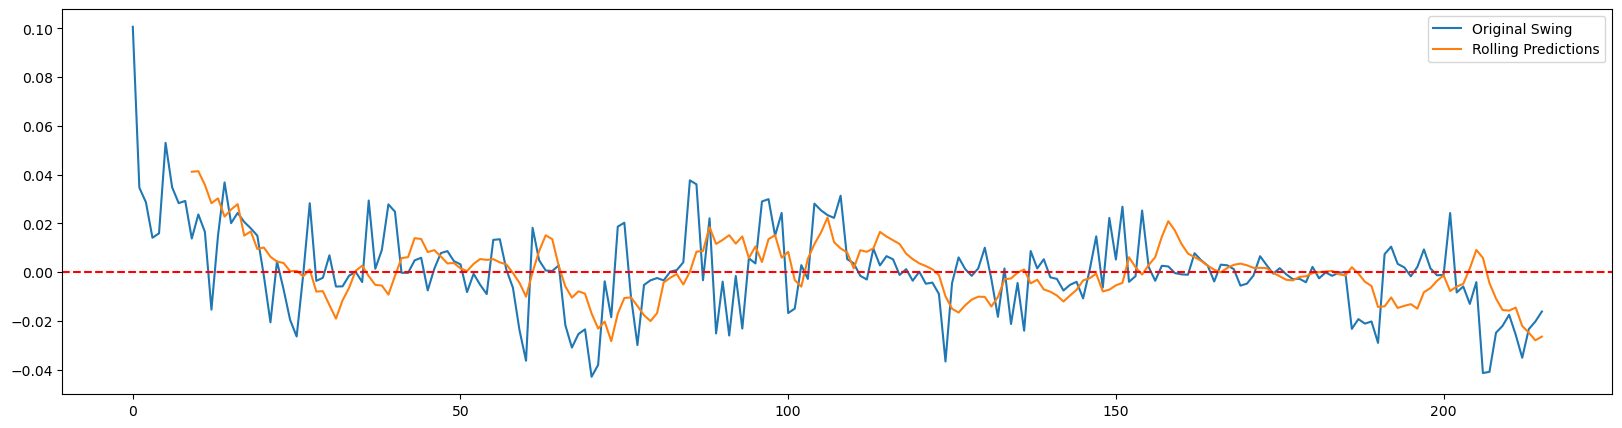

In [430]:
predictions_rolling = pd.Series(predictions).rolling(window=4, min_periods=1).mean()

# plot the original swing data and the rolling predictions
plt.figure(figsize=(20, 5))
plt.plot(swing, label='Original Swing')
plt.plot(range(window_size-1, len(swing)), predictions_rolling, label='Rolling Predictions')

# add a line y = 0
plt.axhline(y=0, color='red', linestyle='--')

plt.legend()
plt.show()

In [431]:
calculateMetrics(swing[window_size-1:], np.array(predictions_rolling))

RMSE: 0.015336452704634806
MAE: 0.011713277320201188
MAPE: 0.011737543714565934
R2: 0.1601829081687235
Pearson correlation coefficient: 0.40022856990565203
Spearman correlation coefficient: 0.36125136647508954


(0.015336452704634806,
 0.011713277320201188,
 0.011737543714565934,
 0.1601829081687235,
 0.40022856990565203,
 0.36125136647508954)

In [432]:
#split into train / test

n = len(swing)
X_train = swing[:int(n*0.8)]
X_test = swing[int(n*0.8):]

In [433]:
# p = 16, q = 4, d = 0
model = arima(X_train, 16, 0, 4)
X_pred = model.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')


/Users/yichao/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [434]:
calculateMetrics(X_test, X_pred)

RMSE: 0.02005831984236024
MAE: 0.01434060203263998
MAPE: 0.014641683490268719
R2: 0.14410480294845288
Pearson correlation coefficient: -0.3796113841133494
Spearman correlation coefficient: -0.3760394644115574


(0.02005831984236024,
 0.01434060203263998,
 0.014641683490268719,
 0.14410480294845288,
 -0.3796113841133494,
 -0.3760394644115574)

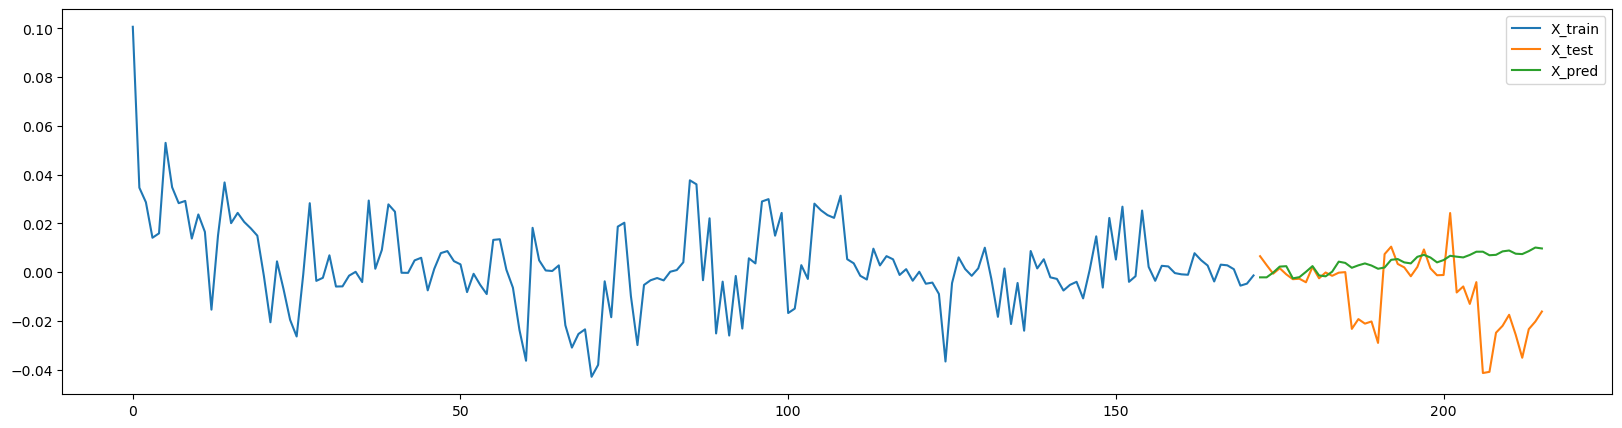

In [435]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(X_train, label='X_train')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test, label='X_test')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_pred, label='X_pred')
plt.legend()
plt.show()
